# Building the Machine Learning Models

During EDA we found out that, with regards to statistical measures in this exercise (PTS, STL, AST, BLK etc), NBA centers from the US and EU are essentially the same. Put another way, the statistical measures for (which we will build our predictive models) are independant of the 'US or EU' column. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
plt.rcParams["figure.figsize"] = [18,10]

with open("C:/Users/Lukas Buteliauskas/Desktop/Springboard Projects/Capstone Project 1 - NBA Analytics/"
          "3. Exploratory Data Analysis/Player Data Filtered.csv", "r") as player_data_file:
    player_data_df=pd.read_csv(player_data_file)
    
player_data_df_undrafted=player_data_df[player_data_df["Draft Placing"].isnull()].reset_index(drop=True) #undrafted player data
player_data_df=player_data_df[player_data_df["Draft Placing"].isnull()==False].reset_index(drop=True) # drafted player data

player_data_og=player_data_df # keeping a copy of the input data (for drafted players)
player_data_df=player_data_df.loc[(player_data_df["eFG%"]!=0.0) & (player_data_df["eFG%"]!=100.0)] # filtering out 0 or 100 eFG%
player_data_df=player_data_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,13]].reset_index(drop=True) #dropping US or EU

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Given that undrafted players make up a sizeable amount of data, and are themselves a specific group of players, their data cannot be disregarded, but at the same time the Draft Rank cannot be reverse engineered. Hence, it makes sense to consider both groups as distinct, and attempt to build models for both seperately. We will begin with models for drafted players.

### Defining the Classifier Performance Printing/Testing Functions

In [2]:
def performance_prints(clf, X_train, X_test, y_train, y_test, cv=5, n_test_print=20): # some performance/test prints
    print("Training performance (R^2): %.3f" % clf.score(X_train, y_train))
    print("Testing performance (R^2): %.3f" % clf.score(X_test, y_test))
    scores=cross_val_score(clf, X_train, y_train, cv=cv)
    print("R^2 cross val mean: %.3f" % (scores.mean()))
    print("95%% confidence interval for R^2: (%.3f, %.3f)" % (scores.mean()-scores.std()*2, scores.mean()+scores.std()*2))
    print("Mean Squared Error (MSE): %.3f\n\nSome test prints:" % mean_squared_error(y_test, y_pred))

    for idx, data in enumerate(zip(y_test, y_pred)): 
        if idx<n_test_print:
            print("Actual: %.2f\t  Predicted: %.2f\tDifference (absolute): %.3f" % (data[0], data[1], np.abs(data[0]-data[1])))
            
def my_resid_plot(y_test, y_pred, label_name="", standardized=False): # for showing us the residual plots
    residuals=y_test-y_pred
    if standardized is True:
        residuals/=np.std(residuals)
        plt.scatter(y_pred, residuals, color="black")
        plt.title("Residual Plot")
        plt.xlabel("Predicted " + label_name + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show()
    else:
        plt.scatter(y_pred, residuals, color="black")
        plt.title("Residual Plot")
        plt.xlabel("Predicted " + label_name + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show()
        
def my_resid_plots(y_test, y_pred, X_test, columns): # residual plots for the features
    residuals=y_test-y_pred
    print("Heteroscendasticity hypothesis test p value:", het_breuschpagan(resid=residuals, exog_het=X_test)[1])
    for idx, column in enumerate(columns):
        plt.scatter(X_test[:,idx], residuals, color="black")
        plt.title("Residual Plot for "+ column)
        plt.xlabel(column + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show() 
    
def prediction_plot(y_test, y_pred, label_name=""): # for showing actual values vs predicted values
    plt.scatter(y_test, y_pred, color="black")
    plt.title("Actual vs Predicted " + label_name + " Plot")
    plt.xlabel("Actual " + label_name + " Values")
    plt.ylabel("Predicted " + label_name + " Values")
    plt.show()
    
def my_normalizer(data, info_print=False): # transform the independant variables, return normalised version
    
    if isinstance(data, pd.DataFrame): # if 'data' is a dataframe
        new_df=data
        transformed_columns=[]
        for column in new_df.columns:
            if np.min(new_df[column]>=1) and column!="eFG%":
                new_df[column]=boxcox(player_data_df[column].values)[0]
                transformed_columns.append(column)
        if info_print is True:
            return new_df, transformed_columns
        else:
            return new_df
    else: # if 'data' is a multi-dimentional array
        new_array=data
        transformed_indices=[]
        for col_idx in range(new_array.shape[1]):
            if np.min(new_array[:,col_idx]>=1):
                new_array[:,col_idx]=boxcox(data[:,col_idx])[0]
                transformed_indices.append(col_idx)
        if info_print is True:
            return new_array, transformed_indices
        else:
            return new_array        

## Points per Game (PTS column) Model

Training performance (R^2): 0.808
Testing performance (R^2): 0.820
R^2 cross val mean: 0.805
95% confidence interval for R^2: (0.773, 0.838)
Mean Squared Error (MSE): 5.736

Some test prints:
Actual: 2.50	  Predicted: 3.20	Difference (absolute): 0.695
Actual: 18.30	  Predicted: 16.06	Difference (absolute): 2.242
Actual: 3.40	  Predicted: 5.44	Difference (absolute): 2.036
Actual: 5.10	  Predicted: 7.03	Difference (absolute): 1.933
Actual: 3.00	  Predicted: 3.07	Difference (absolute): 0.067
Actual: 1.50	  Predicted: 0.36	Difference (absolute): 1.141
Actual: 1.10	  Predicted: -0.27	Difference (absolute): 1.374
Actual: 8.50	  Predicted: 9.50	Difference (absolute): 1.003
Actual: 1.70	  Predicted: 1.82	Difference (absolute): 0.116
Actual: 11.80	  Predicted: 15.65	Difference (absolute): 3.850
Actual: 0.80	  Predicted: -1.44	Difference (absolute): 2.239
Actual: 21.00	  Predicted: 15.11	Difference (absolute): 5.885
Actual: 2.50	  Predicted: 2.77	Difference (absolute): 0.274
Actual: 17.20	  Pred

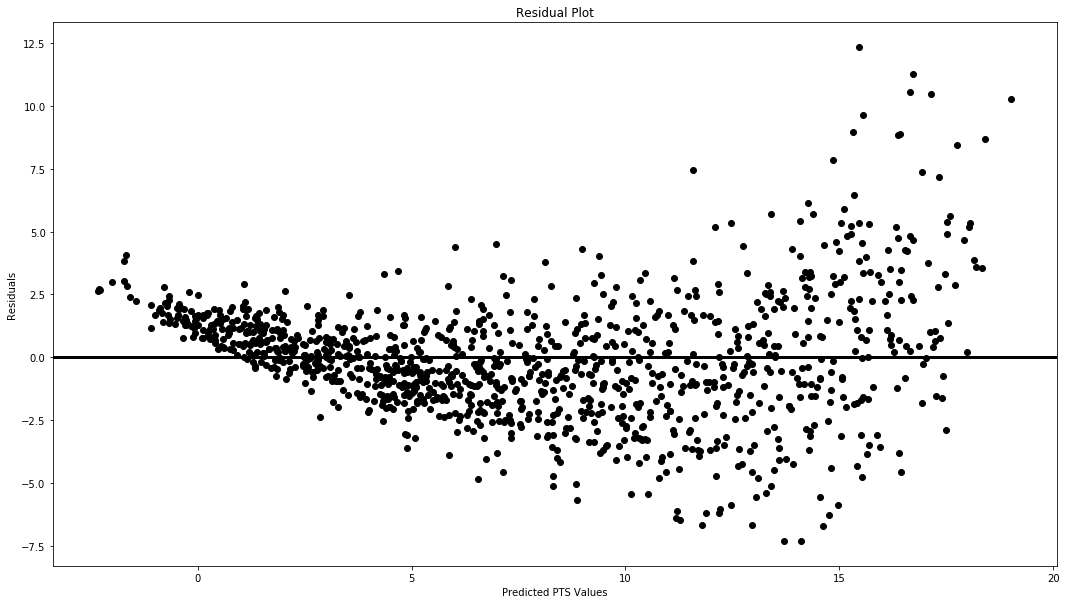

In [3]:
X_eda=player_data_df[["Draft Placing", "eFG%", "Age", "MP"]] # creating a dataframe of only the features selected from EDA.
y=player_data_df["PTS"] # the dependant variable
X_train, X_test, y_train, y_test=train_test_split(X_eda, y, test_size=0.3, random_state=42)

clf_pts=LinearRegression().fit(X_train, y_train) #building/training the model
y_pred=clf_pts.predict(X_test) # predicting on the test set

performance_prints(clf_pts, X_train, X_test, y_train, y_test) #printing out the R^2 values for the training and testing sets
my_resid_plot(y_test, y_pred, label_name="PTS") # diagnosing the residuals of the model

Though the R^2 is quite high, the residual plot shows us that our model is biased. That is, the values of the errors in our predicitions (residuals) are not independant of the predicted values. Furthermore there is distinct increase in the spread of the residuals as well as a U-shape. All of the prior mean that perhaps we need to transform our data to achieve a model that fits the data better. The next logical step would be include polynomial transformations of the existing features. Given the scatter plots of the independant variables against PTS, we saw at most 1 point of inflection, this means we only need to consider 2nd order polynomials. Another consideration is the curse of dimentionality that would arise if we considered 3rd order polynomial features. Let us try this approach and see if our model performs better.

Training performance (R^2): 0.858
Testing performance (R^2): 0.862
R^2 cross val mean: 0.855
95% confidence interval for R^2: (0.838, 0.872)
Mean Squared Error (MSE): 4.383

Some test prints:
Actual: 2.50	  Predicted: 3.37	Difference (absolute): 0.869
Actual: 18.30	  Predicted: 18.05	Difference (absolute): 0.252
Actual: 3.40	  Predicted: 4.59	Difference (absolute): 1.189
Actual: 5.10	  Predicted: 5.77	Difference (absolute): 0.673
Actual: 3.00	  Predicted: 3.02	Difference (absolute): 0.017
Actual: 1.50	  Predicted: 1.75	Difference (absolute): 0.249
Actual: 1.10	  Predicted: 1.73	Difference (absolute): 0.631
Actual: 8.50	  Predicted: 7.64	Difference (absolute): 0.856
Actual: 1.70	  Predicted: 2.61	Difference (absolute): 0.911
Actual: 11.80	  Predicted: 17.11	Difference (absolute): 5.306
Actual: 0.80	  Predicted: 0.64	Difference (absolute): 0.155
Actual: 21.00	  Predicted: 16.43	Difference (absolute): 4.573
Actual: 2.50	  Predicted: 3.23	Difference (absolute): 0.727
Actual: 17.20	  Predic

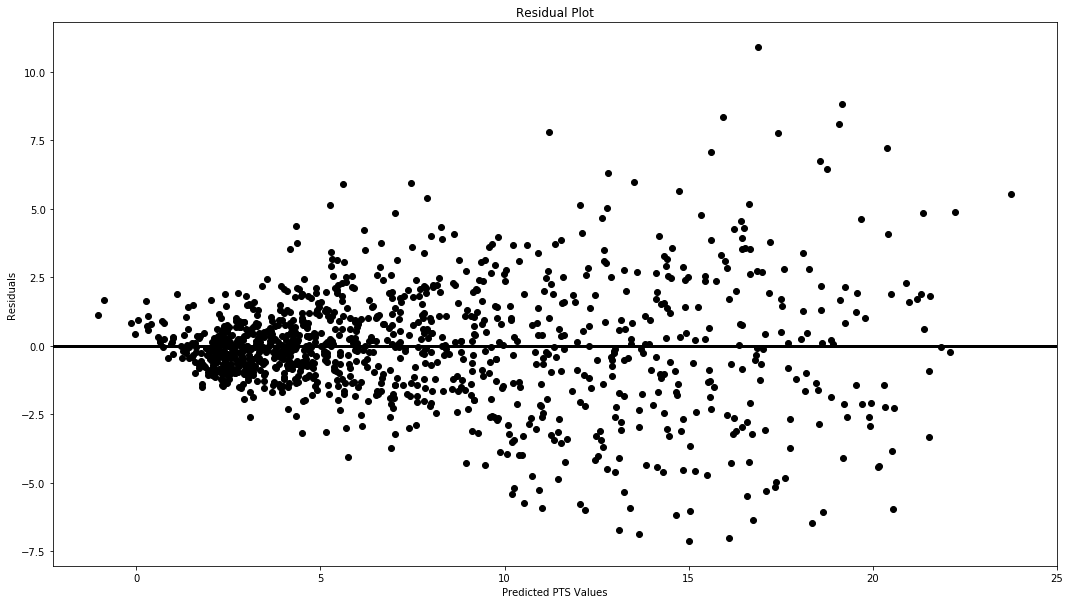

In [4]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["PTS"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

By introducing polynomial features we have succeeded in reducing bias (as demonstrated by a more random residual plot) and also reduced the MSE from 5.7 to 4.3, however heteroscedasticity is still present so we will need to deal with that at some point. Also, having computed 5-fold cross validation we can be confident in our model's ability to generalise to unseen data. We will now consider all the features from the dataframe (up to 2nd order polynomial features) and let the selector pick the best 15 to use in the model (15 was chosen arbitrarily).

Training performance (R^2): 0.894
Testing performance (R^2): 0.894
R^2 cross val mean: 0.891
95% confidence interval for R^2: (0.883, 0.900)
Mean Squared Error (MSE): 3.378

Some test prints:
Actual: 2.50	  Predicted: 4.71	Difference (absolute): 2.211
Actual: 18.30	  Predicted: 17.54	Difference (absolute): 0.755
Actual: 3.40	  Predicted: 4.01	Difference (absolute): 0.612
Actual: 5.10	  Predicted: 5.92	Difference (absolute): 0.820
Actual: 3.00	  Predicted: 2.63	Difference (absolute): 0.370
Actual: 1.50	  Predicted: 1.52	Difference (absolute): 0.022
Actual: 1.10	  Predicted: 1.69	Difference (absolute): 0.586
Actual: 8.50	  Predicted: 7.89	Difference (absolute): 0.612
Actual: 1.70	  Predicted: 2.86	Difference (absolute): 1.159
Actual: 11.80	  Predicted: 17.21	Difference (absolute): 5.409
Actual: 0.80	  Predicted: 0.74	Difference (absolute): 0.055
Actual: 21.00	  Predicted: 19.73	Difference (absolute): 1.268
Actual: 2.50	  Predicted: 3.62	Difference (absolute): 1.117
Actual: 17.20	  Predic

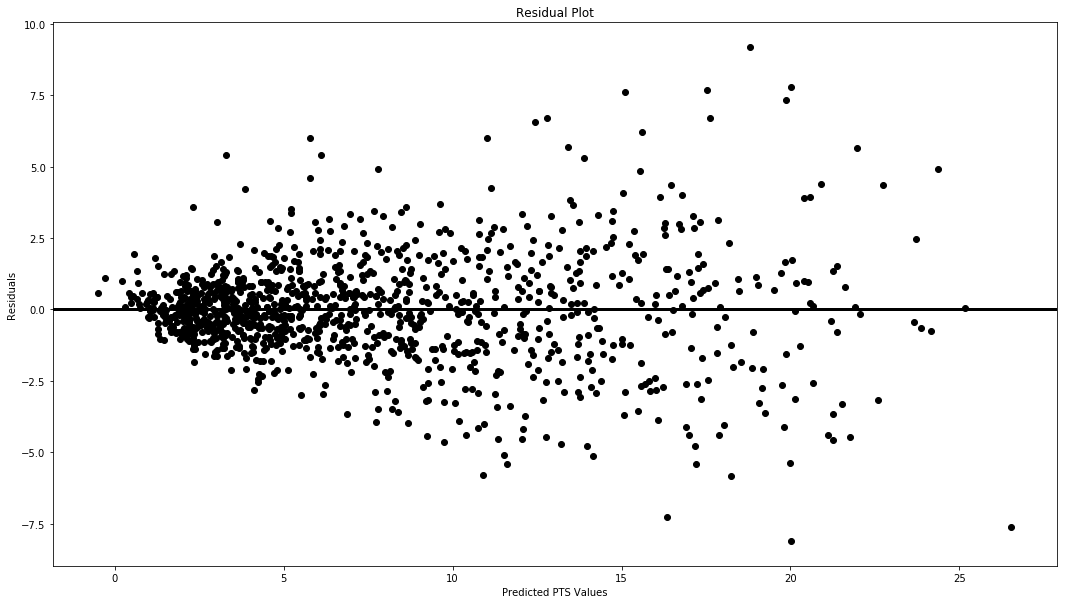

In [5]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]])
y=player_data_df["PTS"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feats=SFS(LinearRegression(), k_features=15, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).fit(X_train, y_train)

X_train, X_test, y_train, y_test=train_test_split(X[:,feats.k_feature_idx_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


All values are finite (no Inf values): True
NaN values are present: False
Training performance (R^2): 0.905
Testing performance (R^2): 0.899
R^2 cross val mean: 0.896
95% confidence interval for R^2: (0.885, 0.908)
Mean Squared Error (MSE): 3.224

Some test prints:
Actual: 2.50	  Predicted: 4.65	Difference (absolute): 2.155
Actual: 18.30	  Predicted: 18.40	Difference (absolute): 0.097
Actual: 3.40	  Predicted: 3.55	Difference (absolute): 0.149
Actual: 5.10	  Predicted: 6.10	Difference (absolute): 1.002
Actual: 3.00	  Predicted: 2.51	Difference (absolute): 0.488
Actual: 1.50	  Predicted: 1.45	Difference (absolute): 0.049
Actual: 1.10	  Predicted: 1.55	Difference (absolute): 0.446
Actual: 8.50	  Predicted: 7.21	Difference (absolute): 1.290
Actual: 1.70	  Predicted: 2.45	Difference (absolute): 0.749
Actual: 11.80	  Predicted: 17.53	Difference (absolute): 5.727
Actual: 0.80	  Predicted: 0.95	Difference (absolute): 0.154
Actual: 21.00	  Predicted: 18.25	Difference (absolute): 2.748
Actual: 

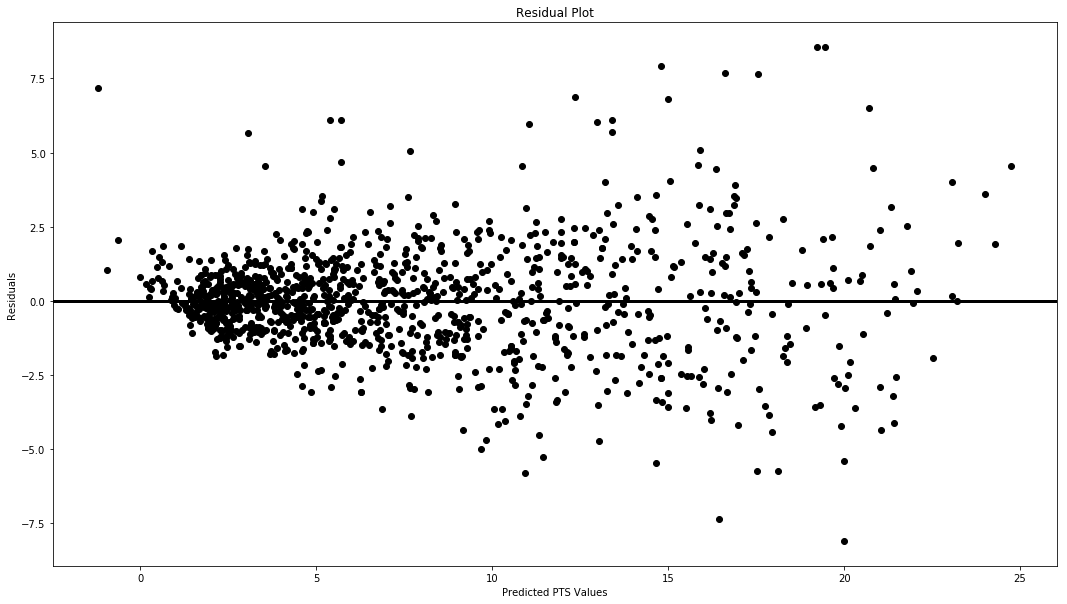

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\sklearn\linear_model\base.py:221: RuntimeWarning: invalid value encountered in sqrt
  sample_weight = np.sqrt(sample_weight)


ValueError: array must not contain infs or NaNs

In [6]:
player_data_pts=my_normalizer(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]])
poly_feat=PolynomialFeatures(degree=2).fit(player_data_pts)
X=poly_feat.transform(player_data_pts)
y=player_data_df["PTS"]
#y=boxcox(player_data_df["PTS"].values)[0]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
"""for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]].columns), feat_selector.ranking_):
   print(name, rank)"""
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

weights=(1/(y_train-clf_pts.predict(X_train))).values
print("All values are finite (no Inf values):", np.isfinite(weights).all())
print("NaN values are present:", np.isnan(weights).any())

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

clf_pts=LinearRegression().fit(X_train, y_train, sample_weight=weights)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

## Assists per Game (AST column) Model

In [ ]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["AST"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")

In [ ]:
"""X=player_data_df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]]
y=player_data_df.AST
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
X_train, X_test, y_train, y_test=train_test_split(X.iloc[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)


performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")
my_resid_plots(y_test, y_pred, X_test=X_test.values, columns=X_test.columns)


"""
player_data_ast=my_normalizer(player_data_df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]])
poly_feat=PolynomialFeatures(degree=2).fit(player_data_ast)
X=poly_feat.transform(player_data_ast)
y=player_data_df.AST

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
"""for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]].columns), feat_selector.ranking_):
   print(name, rank)"""
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

y_not_real=clf_ast.predict(X_train)
residuals=y_train-y_not_real
weights=(1/residuals).values

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")

**INSERT ASSIST COMMENTS HERE**


## Total Rebounds per Game (TRB column) Model

In [ ]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,9,10,12]])
y=player_data_df["TRB"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_trb=LinearRegression().fit(X_train, y_train)
y_pred=clf_trb.predict(X_test)

performance_prints(clf_trb, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="TRB")

Like in the PTS model case, the residuals are roughly randomly distributed, however for higher predicted values we see a slightly larger variance in the residuals.

## Blocks per Game (BLK column) Model

In [ ]:
X=player_data_df.iloc[:,[0,2,3,5,6,8,10,11]]
y=player_data_df.BLK

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
clf_blk=LinearRegression().fit(X_train, y_train)
y_pred=clf_blk.predict(X_test)

performance_prints(clf_blk, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="BLK")

This is totally horrible, we need to do something different.

## Steals per Game (STL column) Model

In [ ]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,12]])
#X=player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,12]]
y=player_data_df.STL
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_stl=LinearRegression().fit(X_train, y_train)
y_pred=clf_stl.predict(X_test)

performance_prints(clf_stl, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="STL")